In [1]:
# Import machine-learning packages
import torch
from torch import nn

# Import plotting packages
from IPython.display import Image, HTML
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import time
import base64
import numpy as np

%matplotlib inline

In [2]:
import xarray as xr

In [32]:
data = xr.open_dataset("../data4training/icepack.h.20150101.nc")
data_x = [data.vice.values[:-1, 2],data.sst.values[:-1, 2], data.sss.values[:-1, 2], data.Tair.values[:-1, 2],data.Qa.values[:-1, 2],data.frain.values[:-1, 2],data.fsnow.values[:-1, 2],data.flw.values[:-1, 2], data.fsw.values[:-1, 2]]
data_y = data.vice.values[1:,2]

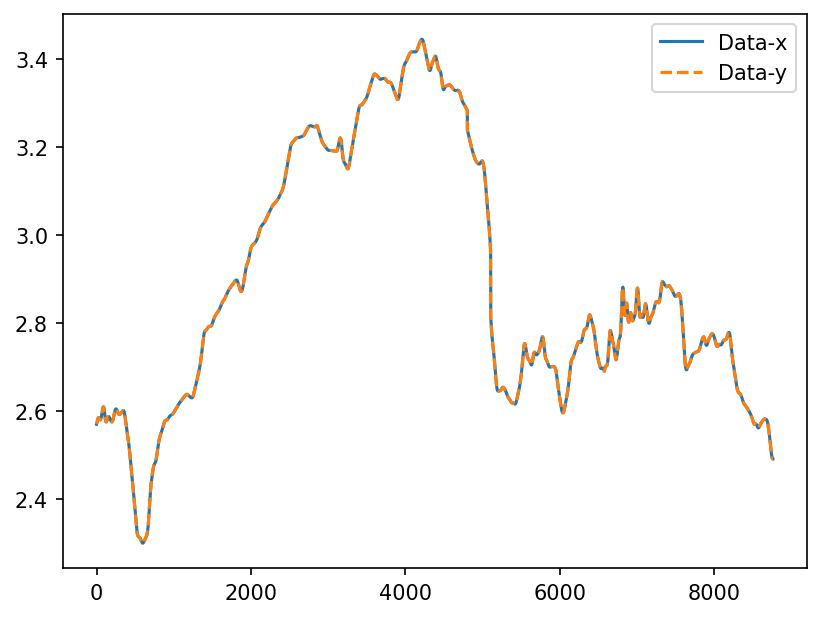

In [95]:
plt.figure(dpi=150)

plt.plot(data_x[0], "-", markersize=1.5, label="Data-x")
plt.plot(data_y, "--", markersize=0.1, label="Data-y")
plt.legend()


In [33]:
n = 24*180
x = torch.ones(n,9)
y = torch.ones(n,1)
for i in range(n):
    x[i][0] = data_x[0][i]
    x[i][1] = data_x[1][i]
    x[i][2] = data_x[2][i]
    x[i][3] = data_x[3][i]
    x[i][4] = data_x[4][i]
    x[i][5] = data_x[5][i]
    x[i][6] = data_x[6][i]
    x[i][7] = data_x[7][i]
    x[i][8] = data_x[8][i]
    y[i] = data_y[i]


In [41]:
class Simple_Neural_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.Dense1 = nn.Linear(9, 30)
        self.Dense2 = nn.Linear(30, 30)
        self.Dense3 = nn.Linear(30, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        # This method is automatically executed when
        # we call a object of this class
        x = self.Dense1(x)
        x = self.relu(x)
        x = self.Dense2(x)
        x = self.relu(x)
        x = self.Dense3(x)

        return x



In [42]:
neural_net = Simple_Neural_Net()

In [45]:
# Here we use the Adam optimizer.
learning_rate = 0.005
optimizer = torch.optim.Adam(neural_net.parameters())

In [46]:
# MSE loss function
loss_fn = torch.nn.MSELoss()

In [47]:
def train_step(model, loss_fn, optimizer):
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices

    pred = model(x)
    loss = loss_fn(pred, y)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss = loss.item()
    return loss

In [48]:
epochs = 1000
Loss = np.zeros(epochs)
for t in range(epochs):
    Loss[t] = train_step(neural_net, loss_fn, optimizer)
    if np.mod(t, 200) == 0:
        print(f"Loss at Epoch {t+1} is ", Loss[t])

Loss at Epoch 1 is  119.51209259033203
Loss at Epoch 201 is  0.023531245067715645
Loss at Epoch 401 is  0.01372263953089714
Loss at Epoch 601 is  0.011380993761122227
Loss at Epoch 801 is  0.009738558903336525


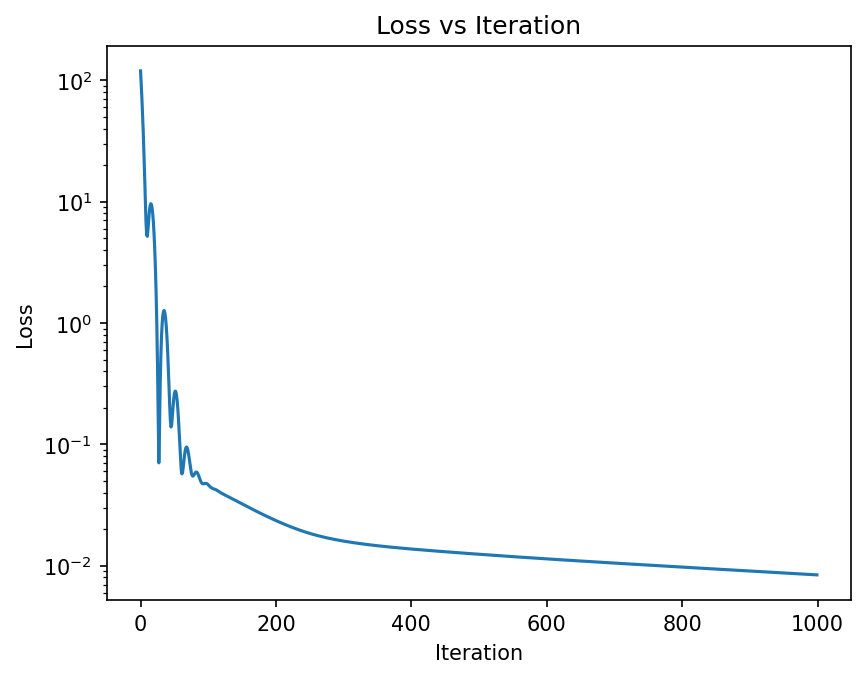

In [49]:
plt.figure(dpi=150)
plt.plot(Loss)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Loss vs Iteration")
plt.show()

In [62]:
# Generate some points where the predictions of the model will be tested.
# Here we pick the testing domain to be larger than the training domain to check if the model
# has any skill at extrapolation.
x_test = torch.ones((n+24*30)-(n+1),9)
for i in range(n+1,n+24*30):
    x_test[i-(n+1)][0] = data_x[0][i]
    x_test[i-(n+1)][1] = data_x[1][i]
    x_test[i-(n+1)][2] = data_x[2][i]
    x_test[i-(n+1)][3] = data_x[3][i]
    x_test[i-(n+1)][4] = data_x[4][i]
    x_test[i-(n+1)][5] = data_x[5][i]
    x_test[i-(n+1)][6] = data_x[6][i]
    x_test[i-(n+1)][7] = data_x[7][i]
    x_test[i-(n+1)][8] = data_x[8][i]

# Generate the predictions from the trained model.
pred = neural_net(x_test).detach().numpy()

4322


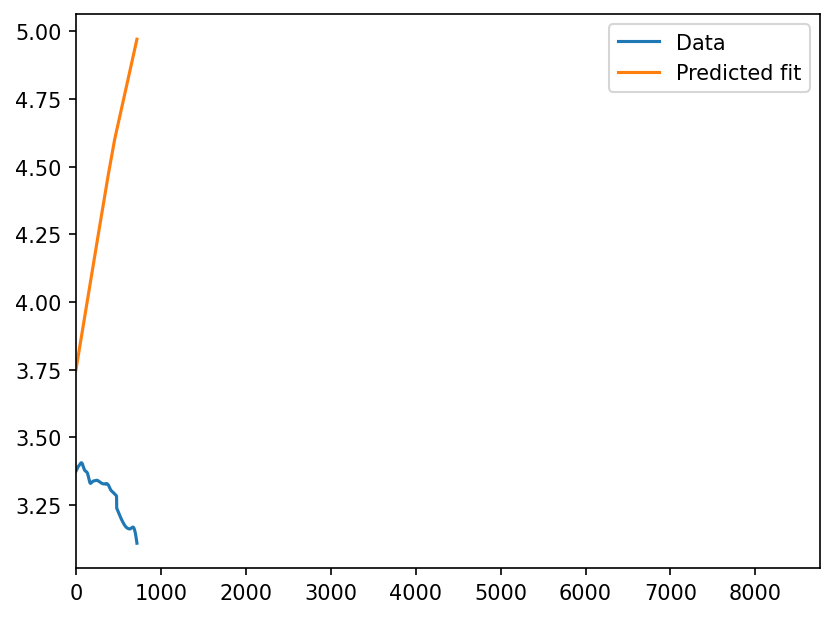

In [100]:
plt.figure(dpi=150)

plt.plot(data_y[n+1+1:n+24*30+1], markersize=0.5, label="Data")
plt.plot(pred, markersize=0.5, label="Predicted fit")
plt.xlim(0,8760)
plt.legend()
print(n+1+1)